# 9: sPlot

This notebook explains __sPlot__ and how to use `zfit` and `hepstats` to compute the sWeights with `compute_sweights`. Alternatively, if the probabilities are already available, `hep_ml.splot` can be used.
__sPlot__ is a way to reconstruct features of mixture components based on known properties of distributions. This method is frequently used in High Energy Physics.

If you prefer explanations without code, find them [here](http://arogozhnikov.github.io/2015/10/07/splot.html)


In [1]:
import mplhep
import numpy as np
import zfit
from matplotlib import pyplot as plt

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
size = 10000
sig_data = np.random.normal(-1, 1, size=size)
bck_data = np.random.normal(1, 1, size=size)

## Simple sPlot example

First we start with a simple (and not very useful in practice) example:

- Assume we have two types of particles (say, electrons and positrons).
- Distribution of some characteristic is different for them (let this be $p_x$ momentum projection).

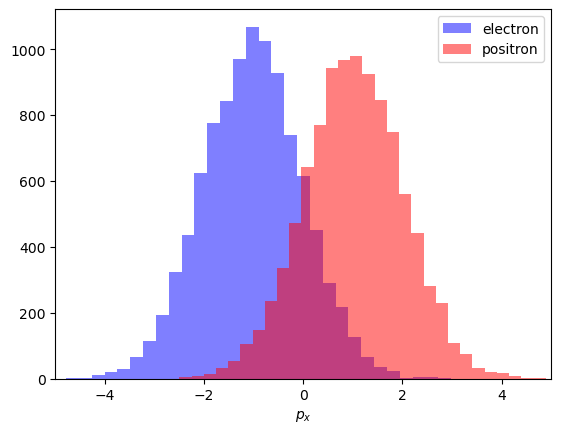

In [3]:
plt.hist(sig_data, color='b', alpha=0.5, bins=30, label='electron')
plt.hist(bck_data, color='r', alpha=0.5, bins=30, label='positron')
plt.xlim(-5, 5), plt.xlabel('$p_x$')
plt.legend()

## Observed distributions

Picture above shows how this distibution should look like,
but due to inaccuracies during classification we will observe a different picture.

Let's assume that with a probability of 80% particle is classified correctly (and we are not using $p_x$ during classification).

And when we look at distribution of px for particles which were classified as electrons or positrons, we see that they were distorted.
We lost the original shapes of distributions.

In [4]:
n_sig1, n_bck1 = 8000, 2000
n_sig2, n_bck2 = 2000, 8000
first_bin = np.concatenate([sig_data[:n_sig1], bck_data[:n_bck1]])
second_bin = np.concatenate([sig_data[n_sig1:], bck_data[n_bck1:]])

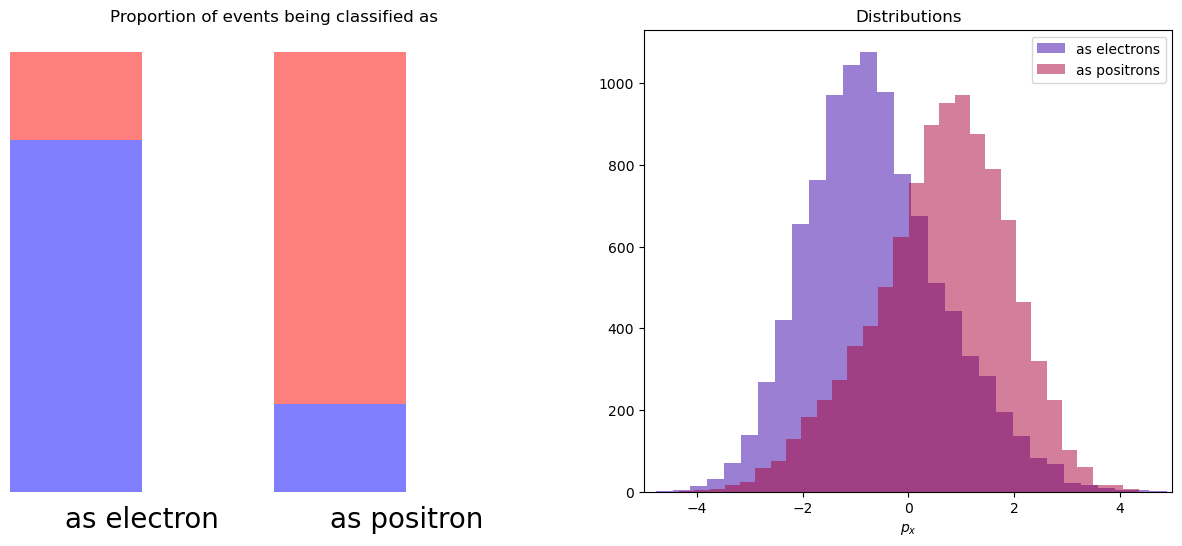

In [5]:
plt.figure(figsize=[15, 6])
plt.subplot(121)
plt.bar([0, 2], [n_sig1, n_sig2], width=1, color='b', alpha=0.5)
plt.bar([0, 2], [n_bck1, n_bck2], width=1, bottom=[n_sig1, n_sig2], color='r', alpha=0.5)
plt.xlim(-0.5, 3.5)

plt.axis('off')
plt.xticks([0.5, 2.5], ['as electrons', 'as positrons'])
plt.text(0.5, -300, 'as electron', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(2.5, -300, 'as positron', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.title('Proportion of events being classified as')

plt.subplot(122)
plt.hist(first_bin, alpha=0.5, bins=30, label='as electrons', color=(0.22, 0., 0.66))
plt.hist(second_bin, alpha=0.5, bins=30, label='as positrons', color=(0.66, 0., 0.22))
plt.legend()
plt.title('Distributions')
plt.xlim(-5, 5), plt.xlabel('$p_x$')
pass

## Applying sWeights

We can think of it in the following way: there are 2 bins. In first 80% are electrons, 20% are signal. And visa versa in second bin.

To reconstruct initial distribution, we can plot histogram, where each event from first bin has weight 0.8,
and each event from second bin has weight -0.2. This numbers are called sWeights.

So, if we had 8000 $e^{-}$ + 2000 $e^{+}$ in first bin and 8000 $e^{+}$ + 2000 $e^{-}$ ($ e^-, e^+$ are electron and positron). After summing with introduced sWeights:

$$
\big[ 8000 e^{-} + 2000 e^{+} \big] \times 0.8 + \big[ 2000 e^{-} + 8000 e^{+} \big] \times (- 0.2) =
6800 e^{-}
$$

Positrons with positive and negative weights compensated each other, and we will get pure electrons.

At this moment we ignore normalization of sWeights (because it doesn't play role when we want to reconstruct shape).



In [6]:
def plot_with_weights(datas, weights, **kargs):
    assert len(datas) == len(weights)
    data = np.concatenate(datas)
    weight = np.concatenate([np.ones(len(d)) * w for d, w in zip(datas, weights) ])
    plt.hist(data, weights=weight, alpha=0.5, bins=30, **kargs)

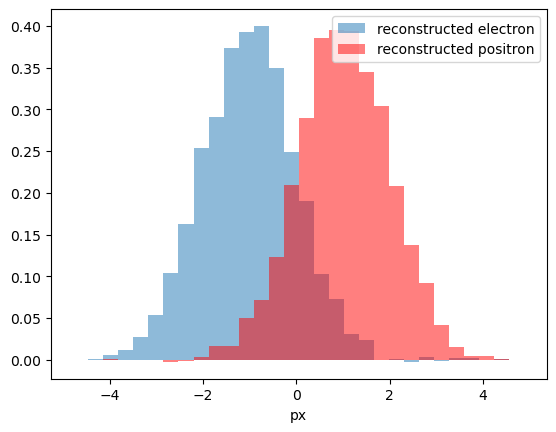

In [7]:
plot_with_weights([first_bin, second_bin], [n_bck2, -n_bck1], density=True, label='reconstructed electron')
plot_with_weights([first_bin, second_bin], [-n_sig2, n_sig1], density=True, color='r', label='reconstructed positron')
plt.xlabel('px')
plt.legend();

### Compare

let's compare reconstructed distribution for electrons with an original one:

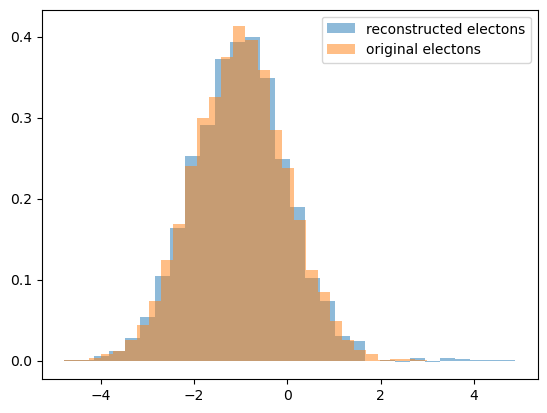

In [8]:
plot_with_weights([first_bin, second_bin], [n_bck2, -n_bck1], density=True, label='reconstructed electons', edgecolor='none')
plot_with_weights([sig_data], [1], density=True, label='original electons', edgecolor='none')
plt.legend();

## More complex case

In the case when we have only two 'bins' is simple and straightforward. But when there are more than two bins, the solution is not unique. There are many appropriate combinations of sWeights, which one to choose?

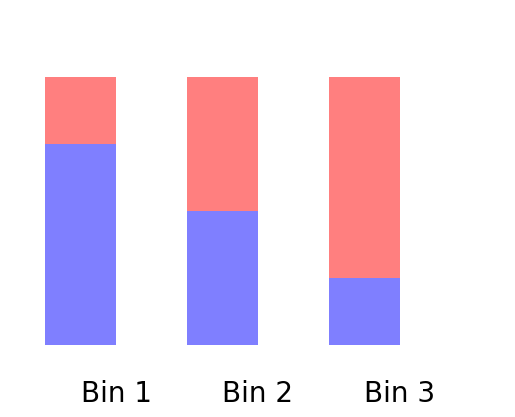

In [9]:
plt.bar([0, 2, 4], [3, 2, 1], width=1, color='b', alpha=0.5)
plt.bar([0, 2, 4], [1, 2, 3], width=1, bottom=[3, 2, 1], color='r', alpha=0.5)

plt.xlim(-1, 6)
plt.ylim(-0.5, 5)
plt.axis('off')

plt.text(0.5, -0.5, 'Bin 1', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(2.5, -0.5, 'Bin 2', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(4.5, -0.5, 'Bin 3', horizontalalignment='center', verticalalignment='top', fontsize=20)
pass

Things in practice are however even more complex. We have not bins, but continuos distribution (which can be treated as many bins).

Typically this is a distribution over mass. By fitting mass we are able to split mixture into two parts: signal channel and everything else.



## Splot

This is now an demonstration of the **sPlot** algorithm, described in [Pivk:2004ty](https://arxiv.org/pdf/physics/0402083.pdf).

If a data sample is populated by different sources of events, like signal and background, **sPlot** is able to unfold the contributions of the different sources for a given variable.

Let's construct a dataset with two variables, the invariant mass and lifetime, for the resonant signal defined above and the combinatorial background. To do this, we build the model in zfit.

In [10]:
mu = zfit.Parameter('mu', 5279, 5100, 5400)
sigma = zfit.Parameter('sigma', 20, 1, 200)

lambd = zfit.Parameter('lambda', -0.002, -0.01, 0.0001)

In [11]:
obs = zfit.Space('mass', (5000, 6000))

signal_pdf = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
comb_bkg_pdf = zfit.pdf.Exponential(lambd, obs=obs)

sig_yield = zfit.Parameter('sig_yield', 25000, 0, 50000,
                                step_size=1)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 100000, 0, 3e5, step_size=1)

# Create the extended models
extended_sig = signal_pdf.create_extended(sig_yield)
extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

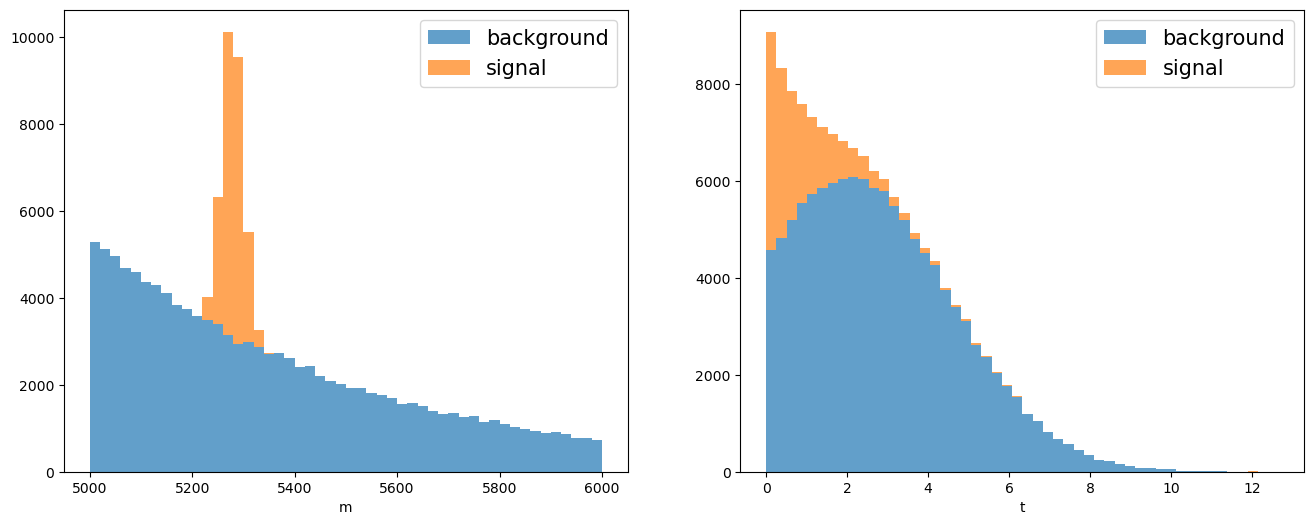

In [12]:
# Signal distributions.
nsig_sw = 20000
np_sig_m_sw = signal_pdf.sample(nsig_sw).numpy().reshape(-1,)
np_sig_t_sw = np.random.exponential(size=nsig_sw, scale=1)

# Background distributions.
nbkg_sw = 150000
np_bkg_m_sw = comb_bkg_pdf.sample(nbkg_sw).numpy().reshape(-1,)
np_bkg_t_sw = np.random.normal(size=nbkg_sw, loc=2.0, scale=2.5)

# Lifetime cut.
t_cut = np_bkg_t_sw > 0
np_bkg_t_sw = np_bkg_t_sw[t_cut]
np_bkg_m_sw = np_bkg_m_sw[t_cut]

# Mass distribution
np_m_sw = np.concatenate([np_sig_m_sw, np_bkg_m_sw])

# Lifetime distribution
np_t_sw = np.concatenate([np_sig_t_sw, np_bkg_t_sw])

# Plots the mass and lifetime distribution.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist([np_bkg_m_sw, np_sig_m_sw], bins=50, stacked=True, label=("background", "signal"), alpha=.7)
axs[0].set_xlabel("m")
axs[0].legend(fontsize=15)
axs[1].hist([np_bkg_t_sw, np_sig_t_sw], bins=50, stacked=True, label=("background", "signal"), alpha=.7)
axs[1].set_xlabel("t")
axs[1].legend(fontsize=15);

In this particular example we want to unfold the signal lifetime distribution. To do so **sPlot** needs a discriminant variable to determine the yields of the various sources using an <ins>extended</ins> maximum likelihood fit.

In [13]:
# Builds the loss.
data_sw = zfit.Data.from_numpy(obs=obs, array=np_m_sw)
nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
sigma.floating = False

# Minimizes the loss.
minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
result_sw = minimizer.minimize(nll_sw)
print(result_sw.params)

name         value  (rounded)    at limit
---------  ------------------  ----------
bkg_yield              118523       False


sig_yield             19905.1       False


lambda            -0.00199971       False


mu                    5278.74       False

In [14]:
def plot_fit_projection(model, data, nbins=30, ax=None):
    # The function will be reused.
    if ax is None:
        ax = plt.gca()

    lower, upper = data.data_range.limit1d

    # Creates and histogram of the data and plots it with mplhep.
    counts, bin_edges = np.histogram(data.unstack_x(), bins=nbins)
    mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True,
                    label="Data", ax=ax, color="black")

    binwidth = np.diff(bin_edges)[0]
    x = np.linspace(lower, upper, num=1000)  # or np.linspace

    # Line plots of the total pdf and the sub-pdfs.
    y = model.ext_pdf(x) * binwidth
    ax.plot(x, y, label="total", color="royalblue")
    for m, l, c in zip(model.get_models(), ["background", "signal"], ["forestgreen", "crimson"]):
        ym = m.ext_pdf(x) * binwidth
        ax.plot(x, ym, label=l, color=c)

    ax.set_title(data.data_range.obs[0])
    ax.set_xlim(lower, upper)
    ax.legend(fontsize=15)

    return ax

<Axes: title={'center': 'mass'}>

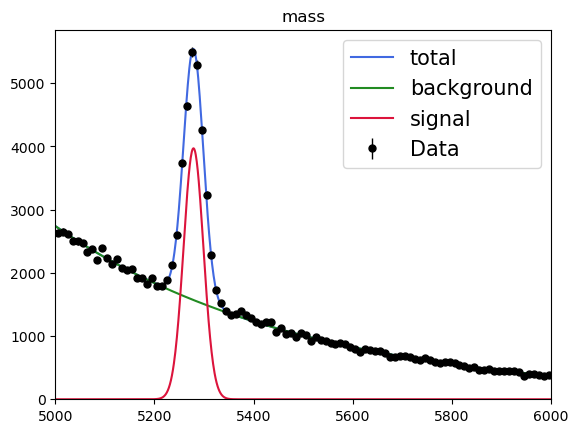

In [15]:
# Visualization of the result.
zfit.param.set_values(nll_sw.get_params(), result_sw)
plot_fit_projection(model, data_sw, nbins=100)

**sPlot** will use the fitted yield for each sources to derive the so-called **sWeights** for each data point:

\begin{equation}
W_{n}(x) = \frac{\sum_{j=1}^{N_S} V_{nj} f_j(x)}{\sum_{k=1}^{N_S} N_{k}f_k(x)}
\end{equation}

with

\begin{equation}
V_{nj}^{-1} = \sum_{e=1}^{N} \frac{f_n(x_e) f_j(x_e)}{(\sum_{k=1}^{N_S} N_{k}f_k(x))^2}
\end{equation}


where ${N_S}$ is the number of sources in the data sample, here 2. The index $n$ represents the source, for instance $0$ is the signal and $1$ is the background, then $f_0$ and $N_0$ are the pdf and yield for the signal.

In `hepstats` the **sWeights** are computed with the `compute_sweights` function which takes as arguments the <ins>fitted</ins> extended model and the discrimant data (on which the fit was performed).

In [16]:
from hepstats.splot import compute_sweights

weights = compute_sweights(model, data_sw)

print(weights)

{<zfit.Parameter 'bkg_yield' floating=True value=1.185e+05>: array([-0.14416085, -0.20457928, -0.15654116, ...,  1.12261428,
        1.12164835,  1.12261003]), <zfit.Parameter 'sig_yield' floating=True value=1.991e+04>: array([ 1.14416019,  1.20457805,  1.15654038, ..., -0.12260304,
       -0.12163712, -0.12259879])}

In [17]:
print("Sum of signal sWeights: ", np.sum(weights[sig_yield]))
print("Sum of background sWeights: ", np.sum(weights[bkg_yield]))

Sum of signal sWeights: 

19905.05646437604

Sum of background sWeights: 

118523.1528198073

Now we can apply the signal **sWeights** on the lifetime distribution and retrieve its signal components.

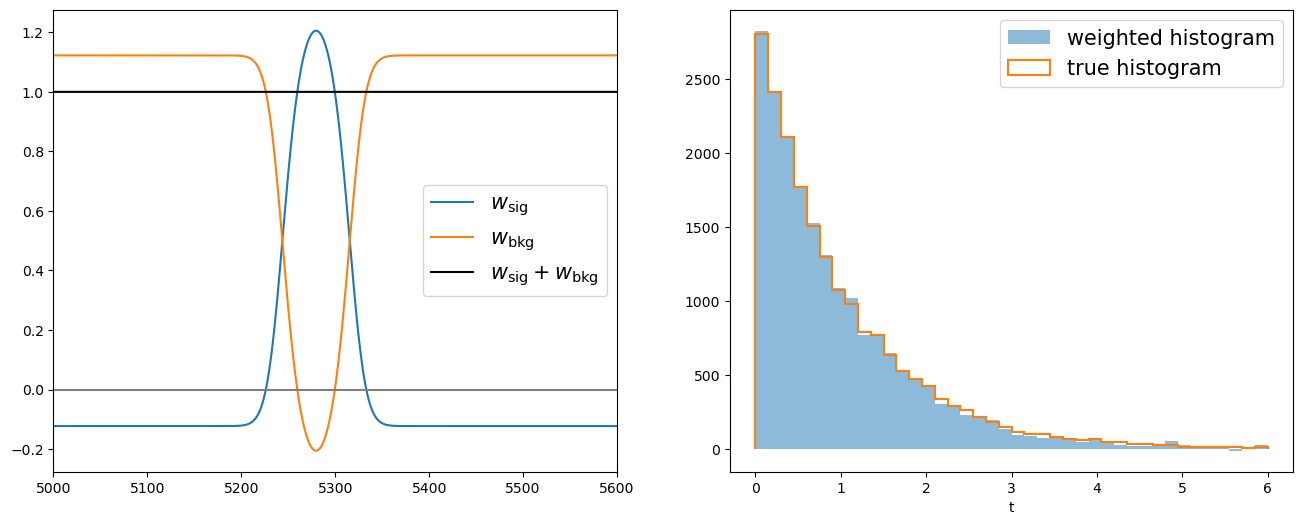

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
nbins = 40

sorter = np_m_sw.argsort()

axs[0].plot(np_m_sw[sorter], weights[sig_yield][sorter], label="$w_\\mathrm{sig}$")
axs[0].plot(np_m_sw[sorter], weights[bkg_yield][sorter], label="$w_\\mathrm{bkg}$")
axs[0].plot(np_m_sw[sorter], weights[sig_yield][sorter] + weights[bkg_yield][sorter],
            "-k", label="$w_\\mathrm{sig} + w_\\mathrm{bkg}$")
axs[0].axhline(0, color="0.5")
axs[0].legend(fontsize=15)
axs[0].set_xlim(5000, 5600)

axs[1].hist(np_t_sw, bins=nbins, range=(0, 6), weights=weights[sig_yield], label="weighted histogram", alpha=.5)
axs[1].hist(np_sig_t_sw, bins=nbins, range=(0, 6), histtype="step", label="true histogram", lw=1.5)
axs[1].set_xlabel("t")
axs[1].legend(fontsize=15);

Be careful the **sPlot** technique works only on variables that are uncorrelated with the discriminant variable.

In [19]:
print(f"Correlation between m and t: {np.corrcoef(np_m_sw, np_t_sw)[0, 1]}")

Correlation between m and t: 0.03176642330619477

Let's apply to signal **sWeights** on the mass distribution to see how bad the results of **sPlot** is when applied on a variable that is correlated with the discrimant variable.

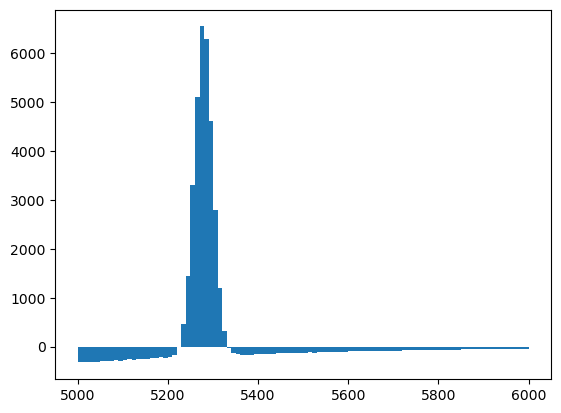

In [20]:
plt.hist(np_m_sw, bins=100, range=(5000, 6000), weights=weights[sig_yield]);

## Alternative: Known probabilities

If the probabilities are already known _beforehand_, fitting a curve with `zfit` is an extra step that is not required in order to obtain the sWeights. The next example uses `hep_ml` in order to compute the sWeights; the same function as `hepstats` also uses internally.

### Building sPlot over mass

Let's show how this works. First we generate two fake distributions (signal and background) with 2 variables: mass and momentum $p$.

In [21]:
from scipy.stats import expon, norm

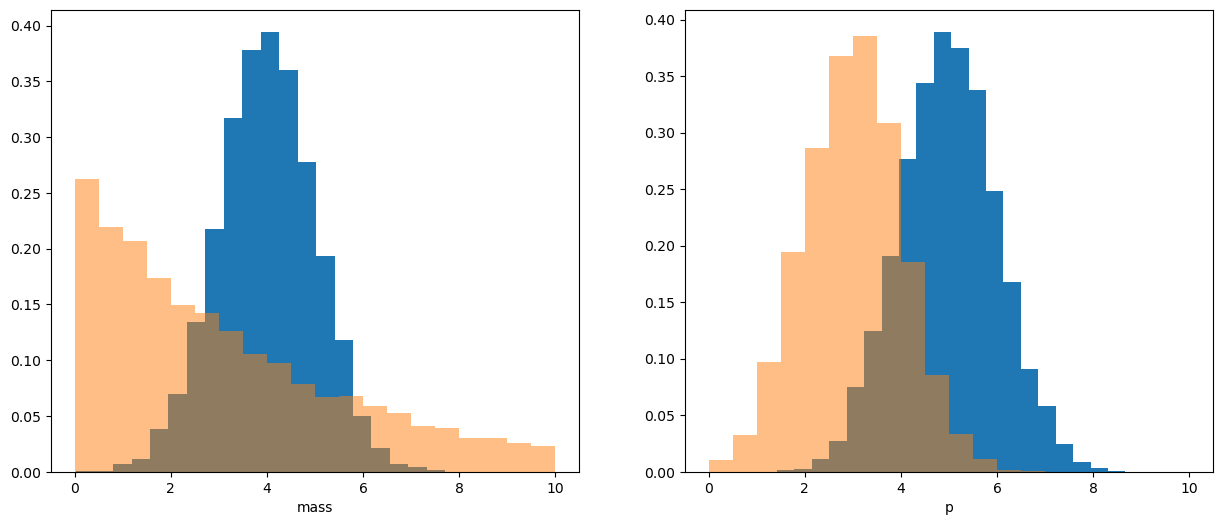

In [22]:
plt.figure(figsize=[15, 6])
size = 10000

sig_mass_distr = norm(loc=4, scale=1)
bck_mass_distr = expon(scale=4)

sig_mass = sig_mass_distr.rvs(size=size)
bck_mass = bck_mass_distr.rvs(size=size)
sig_p = np.random.normal(5, 1, size=size)
bck_p = np.random.normal(3, 1, size=size)

plt.subplot(121)

plt.hist(sig_mass, bins=20, density=True)
plt.hist(bck_mass, bins=20, density=True, range=(0, 10), alpha=0.5)
plt.xlabel('mass')

plt.subplot(122)

plt.hist(sig_p, bins=20, density=True)
plt.hist(bck_p, bins=20, density=True, range=(0, 10), alpha=0.5)
plt.xlabel('p');

### Of course we don't have labels which events are signal and which are background beforehand

And we observe the mixture of two distributions:

Text(0.5, 0, 'p')

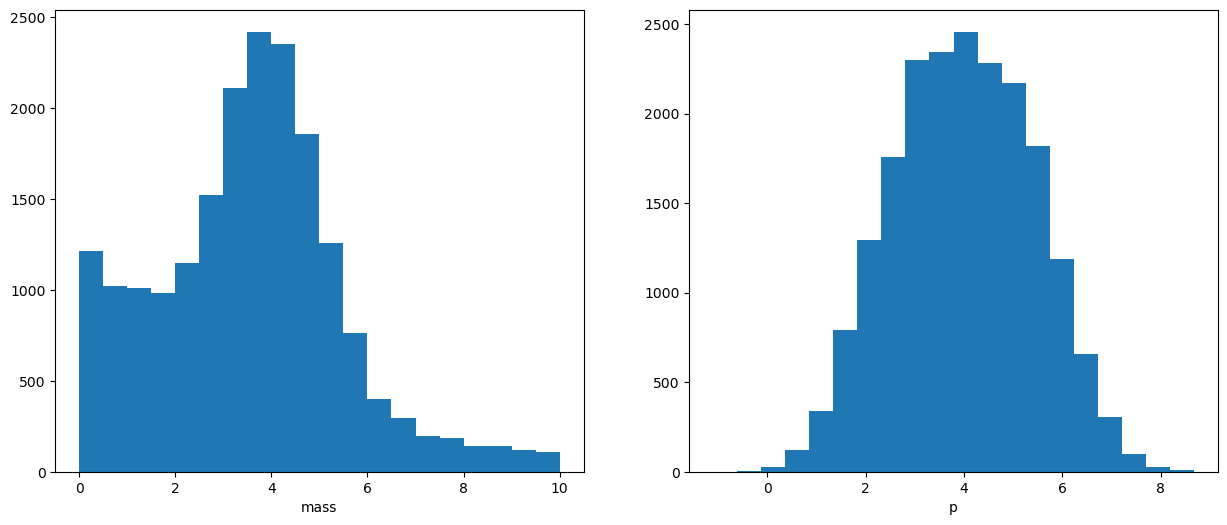

In [23]:
plt.figure(figsize=[15, 6])
mass = np.concatenate([sig_mass, bck_mass])
p = np.concatenate([sig_p, bck_p])

sorter = np.argsort(mass)
mass = mass[sorter]
p = p[sorter]

plt.subplot(121)
plt.hist(mass, bins=20, range=(0, 10))
plt.xlabel('mass')

plt.subplot(122)
plt.hist(p, bins=20)
plt.xlabel('p')

### We have no information about real labels

But we know a priori that background is distributed as exponential distribution and signal - as gaussian (more complex models can be met in practice, but idea is the same).

After fitting the mixture (let me skip this process), we will get the following result:

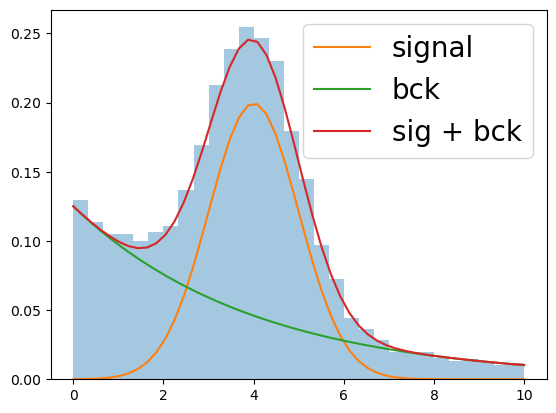

In [24]:
x = np.linspace(0, 10)
plt.hist(mass, bins=30, range=[0, 10], density=True, alpha=0.4)
plt.plot(x, norm.pdf(x, loc=4, scale=1) / 2., label='signal')
plt.plot(x, expon.pdf(x, scale=4) / 2., label='bck')
plt.plot(x, 0.5 * (norm.pdf(x, loc=4, scale=1) + expon.pdf(x, scale=4)), label='sig + bck')
plt.legend(fontsize=20)

## Fitting doesn't give us information about real labels

But it gives an information about probabilities, thus now we can estimate number of signal and background events within each bin.

We won't use bins, but instead we will get for each event probability that it is signal or background:

In [25]:
import pandas

probs = pandas.DataFrame(dict(sig=sig_mass_distr.pdf(mass), bck=bck_mass_distr.pdf(mass)))
probs = probs.div(probs.sum(axis=1), axis=0)

((0.0, 10.0),
 Text(0.5, 0, 'mass'))

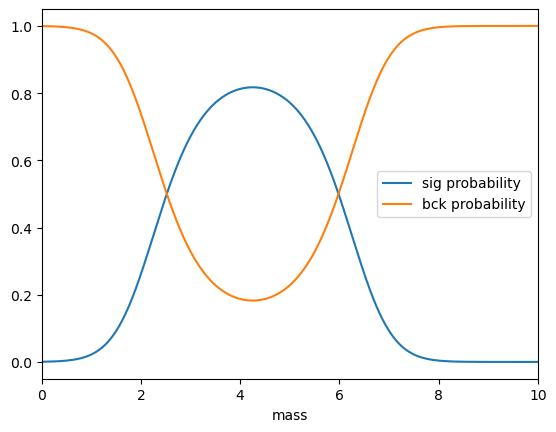

In [26]:
plt.plot(mass, probs.sig, label='sig probability')
plt.plot(mass, probs.bck, label='bck probability')
plt.xlim(0, 10), plt.legend(), plt.xlabel('mass')

## Appying sPlot

sPlot converts probabilities to sWeights, using an implementation from `hep_ml`:


In [27]:
from hep_ml import splot

sWeights = splot.compute_sweights(probs)

As you can see, there are also negative sWeights, which are needed to compensate the contributions of other class.

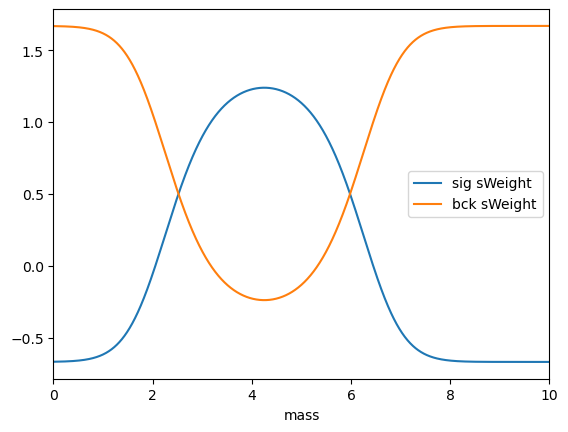

In [28]:
plt.plot(mass, sWeights.sig, label='sig sWeight')
plt.plot(mass, sWeights.bck, label='bck sWeight')
plt.xlim(0, 10), plt.legend(), plt.xlabel('mass');

## Using sWeights to reconstruct initial distribution

Let's check that we achieved our goal and can reconstruct momentum distribution for signal and background:

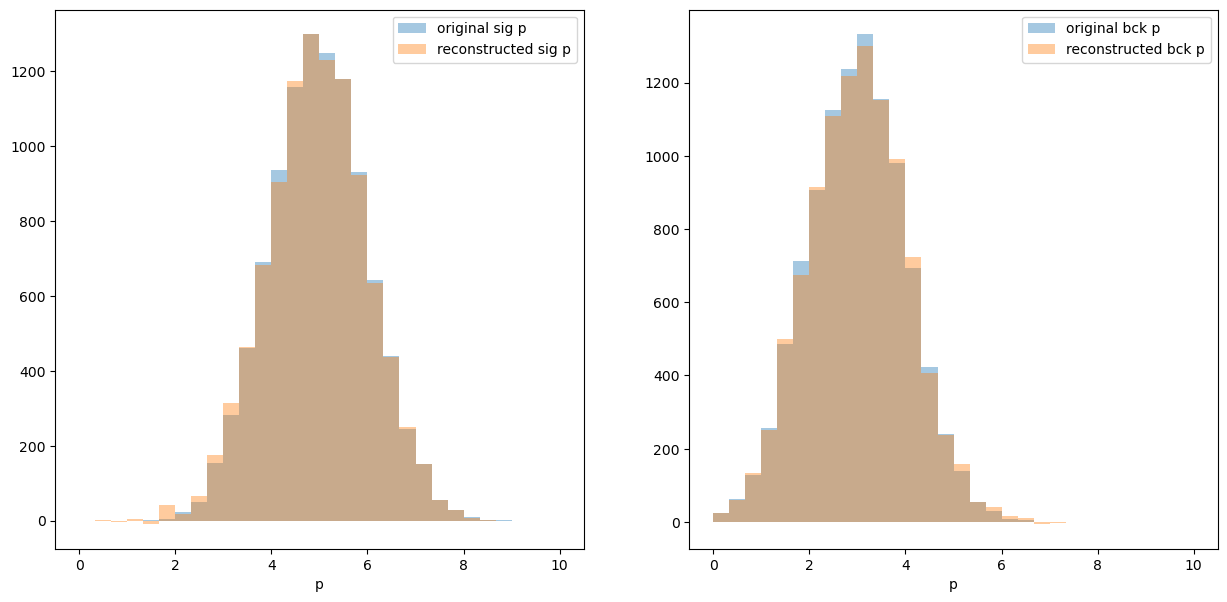

In [29]:
plt.figure(figsize=[15, 7])
plt.subplot(121)
hist_conf = dict(bins=30, alpha=0.4, range=[0, 10])
plt.hist(sig_p, label='original sig p', **hist_conf)
plt.hist(p, weights=sWeights.sig, label='reconstructed sig p', **hist_conf)
plt.xlabel('p'), plt.legend()

plt.subplot(122)
plt.hist(bck_p, label='original bck p', **hist_conf)
plt.hist(p, weights=sWeights.bck, label='reconstructed bck p', **hist_conf)
plt.xlabel('p'), plt.legend()
pass

## An important requirement of sPlot

Reconstructed variable (i.e. $p$) and splotted variable (i.e. mass) shall be statistically independent for each class.

Read the line above again. Reconstructed and splotted variable are correlated:

In [30]:
np.corrcoef(abs(mass - 4), p) [0, 1]

-0.33422614253219946

But within each class there is no correlation, so the requirement is satisfied:

In [31]:
print(np.corrcoef(abs(sig_mass - 4), sig_p)[0, 1])
print(np.corrcoef(abs(bck_mass - 4), bck_p)[0, 1])

0.003932632163211328

0.011306594392630567

as a demonstration why this is important let's use sweights to reconstruct mass (obviously mass is correlated with mass):

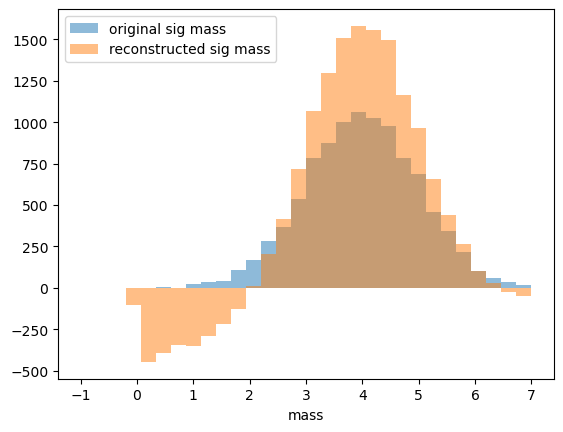

In [32]:
hist_conf = dict(bins=30, alpha=0.5, range=[-1, 7])
plt.hist(sig_mass, label='original sig mass', **hist_conf)
plt.hist(mass, weights=sWeights.sig, label='reconstructed sig mass', **hist_conf)
plt.xlabel('mass'), plt.legend()
pass

$\def\ps{p_s(x)}$
$\def\pb{p_b(x)}$
$\def\ws{sw_s(x)}$
$\def\wb{sw_b(x)}$



## Derivation of sWeights (optional)

Now, after we seen how this works, let's derive a formula for sWeights.



The only information we have from fitting over mass is  $ \ps $, $ \pb$ which are probabilities of event $x$ to be signal and background.

Our main goal is to correctly reconstruct histogram. Let's reconstruct the number of _signal_ events in _particular_ bin. Let's introduce unknown $p_s$ and $p_b$ - probability that signal or background event will be in the named bin.

(Since mass and reconstructed variable are statistically independent for each class, $p_s$ and $p_b$ do not depend on mass.)

The mathematical expectation should be obviously equal to $p_s N_s$, where $N_s$ is total amount of signal events available from fitting.

Let's also introduce random variable $1_{x \in bin}$, which is 1 iff event $x$ lies in selected bin.

The __estimate for number of signal event in bin__ is equal to:
$$X = \sum_x \ws \; 1_{x \in bin},$$ where $\ws$ are sPlot weights and are subject to find.



This way we can guarantee that mean contribution of background are 0 (expectation is zero, but observed number will not be zero due to statistical deviation).

### Under assumption of linearity:

*assuming* that splot weight can be computed as a linear combination of conditional probabilities:

$ \ws = a_1 \pb + a_2 \ps$

We can easily reconstruct those numbers, first let's rewrite our system:

$ \sum_x (a_1 \pb + a_2 \ps) \; \ps = 0$ <br />
$ \sum_x (a_1 \pb + a_2 \ps) \; \pb = N_{sig}$

$ a_1 V_{bb} + a_2 V_{bs} = 0$ <br />
$ a_1 V_{sb} + a_2 V_{ss} = N_{sig}$ <br />

Where
$V_{ss} = \sum_x \ps \; \ps $, $V_{bs} = V_{sb} = \sum_x \ps \; \pb$, $V_{bb} = \sum_x \pb \; \pb$

Having solved this linear equation, we get needed coefficients (as those in the paper)

NB. There is little difference between $V$ matrix I use and $V$ matrix in the paper. <br />


### Minimization of variation
$\def\Var{\mathbb{V}\,}$

Previous part allows one to get the correct result. But there is still no explanation of reason for linearity.


Apart from having correct mean, we should also minimize variation of any reconstructed variable. Let's try to optimize it

$$ \Var X = \sum_x \ws^2 \; \Var 1_{x \in bin} = \sum_x \ws^2 \; (p_s \ps + p_b \pb)(1 - p_s \ps - p_b \pb)$$

A bit complex, isn't it? Instead of optimizing such a complex expression (which is individual for each bin), let's minimize it's __uniform upper estimate__
$$ \Var X = \sum_x \ws^2 \; \Var 1_{x \in bin} \leq  \sum_x \ws^2  $$



so if we are going to minimize this upper estimate, we should solve the following optimization problem with constraints:
<br />$\sum_x \ws^2 \to \min $
<br />$\sum_x \ws \; \pb = 0$
<br />$\sum_x \ws \; \ps = N_{sig}$

Let's write lagrangian of optimization problem:
<br /> $$ \mathcal{L} =  \sum_x \ws^2
+ \lambda_1 \left[\sum_x \ws \; \pb \right]
+ \lambda_2 \left[\sum_x \ws \; \ps - N_{sig} \right]$$

### Uncorrelatedness

The main assuption we used here is that distribution inside each bin is abolutely indentical.

In other words, we stated that there is no correlation between the index of bin and the reconstructed variable. Remember that bin corresponds to some interval in mass, and finaly we get:

__reconstructed variable shall not be correlated with mass variables (or any other splotted variable)__

## Conclusion

1. sPlot allows reconstruction of some variables.
2. the only information used is probabilities taken from fit over variable. If fact, any probability estimates fit well.
3. the source of probabilities should be statistically independent from reconstructed variable (for each class!).
4. mixture may contain more than 2 classes (this is supported by `hep_ml.splot` as well)